<img src="../Pnuemonia_Classifier/KyleDevLogo.jpg" alt="Kyles Logo" style="width: 1000px; border-radius: 2%; margin: auto; display: block;" />

# **Alzheimers Demented Classification**
By: Kyle Hostetter

## Data Information

This was a dataset that was gathered from Kaggle.com that contains 6,400 images of 4 major classes of alzheimers. The classes are non, very mild, mild, and moderate demented. The goal is to create a CNN model that will classify each of these stages with the highest accuracy possible!

**Data**
* Non Demented
* Very Mild Demented
* Mild Demented
* Moderate Demented

## Import Libraries

In [122]:
# Import Base Libraries
import os 
import numpy as np
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt

# Import Deep Learning Libraries
import tensorflow as tf
from keras import layers
from tensorflow import keras

# Set Constant Variables
DATA_DIR = 'Dataset/'
EPOCHS = 15
BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Change TensorFlow settings
os.environ['TF_SPP_MIN_LOG_LEVEL'] = '2'                 # Change the logging output level to 2
physical_cpus = tf.config.list_physical_devices('CPU')   # List all CPU devices       
physical_gpus = tf.config.list_physical_devices('GPU')   # List all GPU devices

# Print out TensorFlow Version
print(f'''Tensorflow Version: {tf.__version__}''')
print(f'''CPU Devices: ''',physical_cpus)
print(f'''GPU Devices: ''',physical_gpus)

Tensorflow Version: 2.16.1
CPU Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU Devices:  []


In [123]:
# All Class Names 
class_names = ['Non Demented', 'Very Mild Demented',
               'Mild Demented', 'Moderate Demented']

# Non Demented Images
non_images = glob(DATA_DIR + 'Non_Demented/*.jpg')

# Very Mild Demented Images
very_mild_images = glob(DATA_DIR + '/Very_Mild_Demented/*.jpg')

# Mild Demented Images
mild_images = glob(DATA_DIR + '/Mild_Demented/*.jpg')

# Moderate Demented Images
moderate_images = glob(DATA_DIR + '/Moderate_Demented/*.jpg')

# Input Data
data = {'Class Name':class_names,
        'Amount of Images':[len(non_images),len(very_mild_images),
                            len(mild_images),len(moderate_images)]}

# Put data into dataframe
files_df = pd.DataFrame.from_dict(data)

# Show data in DataFrame format
display(files_df)

,Class Name,Amount of Images
0,Non Demented,3200
1,Very Mild Demented,2240
2,Mild Demented,896
3,Moderate Demented,64


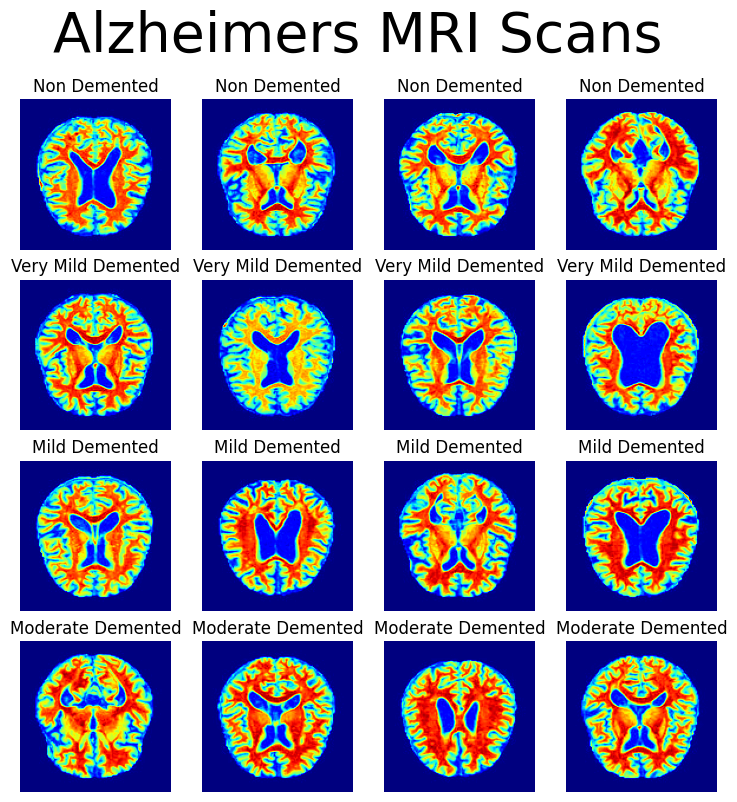

In [125]:
# List of image arrays
image_folders = [non_images,very_mild_images,mild_images,moderate_images]

# Create MRI Image function
def showMRIimages(image_folders, class_names, columns, colorMap, title):
    '''
    Title: Show MRI Images
    Description: This will create and show a plot samples of MRI scans 
    for patients with increasing levels of alzheimers.
    images_folders: List of image arrays.
    class_names: List of class names that correlate indexes with image_folders.
    columns: Number of columns in chart.
    colorMap: Matplotlib Continous Color Map.
    title: Title of chart
    '''
    # Set columns to amount of folders
    rows = len(image_folders)

    # Set Figure Size
    plt.figure(figsize=(columns*2.25,9))
    plt.suptitle(title, fontsize=columns*10)

    # Create Counters
    t=0
    j=1

    # For each Image Folder
    for image_folder in image_folders:

            # Create show 4 images
            for i in range(columns):
                plt.subplot(rows, columns,j)
                plt.imshow(np.asarray(plt.imread(image_folder[i])), cmap=colorMap)
                plt.title(f'''{class_names[t]}''')
                plt.axis('off')
                j=j+1
            t=t+1
    
    # Show Images
    plt.show()

# Show MRI Images
showMRIimages(image_folders=image_folders,
              class_names=class_names,
              columns=4,
              colorMap='jet',
              title='Alzheimers MRI Scans')

In [126]:
# Create Training and testing DataFrames
train_df, test_df = tf.keras.preprocessing.image_dataset_from_directory(directory=DATA_DIR,
                                                                        color_mode='grayscale',
                                                                        label_mode='int',
                                                                        batch_size=BATCH_SIZE,
                                                                        image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),   # Set Height & Width of Images
                                                                        validation_split=.2,
                                                                        subset='both',
                                                                        shuffle=True,
                                                                        seed=0)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Using 1280 files for validation.


In [134]:
# Input matric that uses 2x2 pixels.
MATRIX = (2,2)

# Build Convolution Neural Network
model = keras.Sequential(name='Alzheimers_CNN', layers=
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='Input_Layer'),
        layers.Rescaling(1./255, name='Res_Layer1'),
        
        layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer1'),
        layers.MaxPooling2D(name='Max_Pooling1'),

        layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer2'),
        layers.MaxPooling2D(name='Max_Pooling2'),
        
        layers.Flatten(name='Flatten_Layer'),
        layers.Dense(64, activation='relu', name='Dense_layer'),
        layers.Dense(4, activation='softmax', name='Final_Output')
    ]
)

# Print Out Model Architecture
print(model.summary())

# Run & Compile Deep Learning Model
model.compile(optimizer='adam',                         # Use the Adam optimizer
              loss='sparse_categorical_crossentropy',   # Use sparse crossentropy since there are more than 2 classes
              metrics=['accuracy'])                     # Optimize Accuracy of model

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Create a Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',   # Metric to watch during training 
                                            patience=1)           # Continue training 3 epocks past a decrease in the monitor feature

# Train model
history=model.fit(train_df,                  # Data to train on       
                  validation_data=test_df,   # Validation Data
                  epochs=EPOCHS,             # Number of Epochs 
                  batch_size=BATCH_SIZE,     # Number of samples to train in SGD at a time
                  callbacks=[callback])      # Stop early if there is no increase in model metrics

# Evaluate Model
test_loss, test_score = model.evaluate(test_df,                 # What data to evaluate model on          
                                       batch_size=BATCH_SIZE)   # Number of samples to train in SGD at a time

# Delete Old Model & Save New Keras Model
os.remove('Alzheimers_CNN_Model.keras')
# model.save("Alzheimers_CNN_Model.h5")
model.save("Alzheimers_CNN_Model.keras")

# Print out Final results
print(f'''\n

        Final Model Results
----------------------------------
Accuracy: {round(test_score * 100,1)}%
Loss: {test_loss}
''')

Model: "Alzheimers_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Res_Layer1 (Rescaling)          │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer1 (Conv2D)            │ (None, 128, 128, 32)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling1 (MaxPooling2D)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer2 (Conv2D)            │ (None, 64, 64, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling2 (MaxPooling2D)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer (Dense)             │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Output (Dense)            │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101,764 (8.02 MB)

 Trainable params: 2,101,764 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15


80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 212ms/step - accuracy: 0.4728 - loss: 1.0512 - val_accuracy: 0.5664 - val_loss: 0.9226
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.5929 - loss: 0.8774 - val_accuracy: 0.6352 - val_loss: 0.8158
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.6655 - loss: 0.7732 - val_accuracy: 0.7023 - val_loss: 0.6793
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.7735 - loss: 0.5675 - val_accuracy: 0.7531 - val_loss: 0.5661
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.8543 - loss: 0.3975 - val_accuracy: 0.8266 - val_loss: 0.4341
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 0.9142 - loss: 0.2711 - val_accuracy: 0.8680 - val_loss: 0.3634
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.9342 - loss: 0.2045 - val_accuracy: 0.9008 - val_loss: 0.2822
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.9691 - loss: 0.1270 - val_accuracy: 0.916

In [135]:
y_pred = model.predict(test_df)
print(test_df.class_names)
print(y_pred[2])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
[1.1380924e-05 3.5887149e-06 9.9971348e-01 2.7160670e-04]


In [136]:
def predictImage(model,image):
    # Class Name Labels
    labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

    # Expand image into readalbe image array
    fixed_image = np.expand_dims(image,axis=0)

    # Apply prediciton model
    pred_image = model.predict(fixed_image)

    # Index of highest probability image
    index_max = np.argmax(pred_image)

    # Attach Class Label
    pred = labels[index_max]
    proba = round(pred_image[0][index_max] * 100,2)

    # Return Highest probable label
    return proba, pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


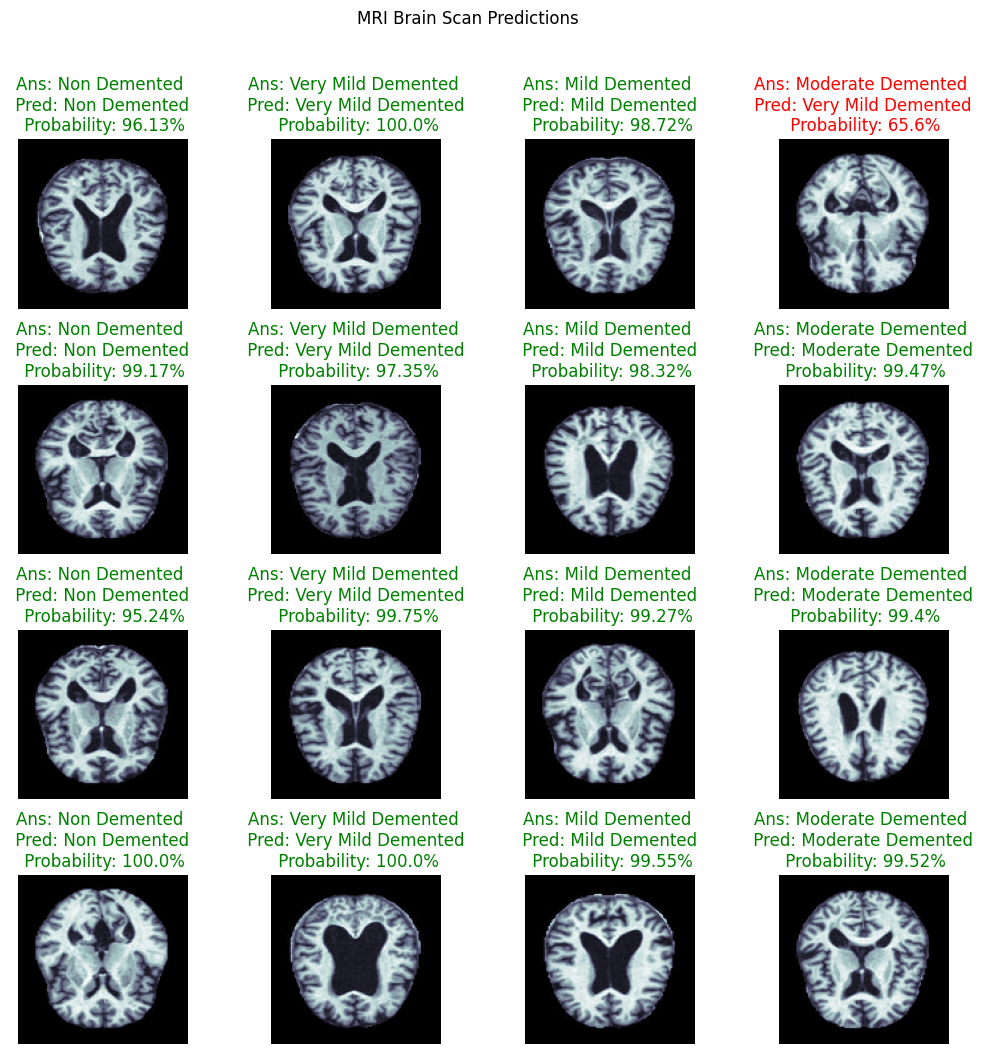

In [137]:
# Figure Variables
rows = 4
colorMap = 'bone'

# Set Figure Size
plt.figure(figsize=(12,12))
plt.suptitle('MRI Brain Scan Predictions')

# Add Counter
j=1

# Plot image for normal lungs
for i in range(rows):

    plt.subplots_adjust(hspace=0.3,wspace=0.5)

    # Build Image & store in variable
    non_image = np.asarray(plt.imread(non_images[i]))
    proba1, pred1 = predictImage(model=model, image=non_image)

    very_mild_image = np.asarray(plt.imread(very_mild_images[i]))
    proba2, pred2 = predictImage(model=model, image=very_mild_image)

    mild_image = np.asarray(plt.imread(mild_images[i]))
    proba3, pred3 = predictImage(model=model, image=mild_image)

    moderate_image = np.asarray(plt.imread(moderate_images[i]))
    proba4, pred4 = predictImage(model=model, image=moderate_image)

    if pred1 == 'Non Demented':
        pred1_color = 'green'
    else:
        pred1_color = 'red'

    if pred2 == 'Very Mild Demented':
        pred2_color = 'green'
    else:
        pred2_color = 'red'

    if pred3 == 'Mild Demented':
        pred3_color = 'green'
    else:
        pred3_color = 'red'

    if pred4 == 'Moderate Demented':
        pred4_color = 'green'
    else:
        pred4_color = 'red'

    plt.subplot(rows, 4, j)
    plt.imshow(non_image, cmap=colorMap)
    plt.title(f'''Ans: Non Demented \n Pred: {pred1} \n Probability: {proba1}%''', color=pred1_color)
    plt.axis('off')
    j = j+1
    
    plt.subplot(rows,4,j)
    plt.imshow(very_mild_image, cmap=colorMap)
    plt.title(f'''Ans: Very Mild Demented \n Pred: {pred2} \n Probability: {proba2}%''', color=pred2_color)
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(mild_image, cmap= colorMap)
    plt.title(f'''Ans: Mild Demented \n Pred: {pred3} \n Probability: {proba3}%''', color=pred3_color)
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(moderate_image, cmap=colorMap)
    plt.title(f'''Ans: Moderate Demented \n Pred: {pred4} \n Probability: {proba4}%''', color=pred4_color)
    plt.axis('off')
    j = j+1